# Supplemental: Spatial Autocorrelation in Cortical Timescale
Exploring different ways of accounting for spatial autocorrelation, mainly following variogram method from brainSMASH (Burt et al., 2020, bioRxiv) and Moran Eigenvector Map from BrainSpace ().

In [216]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
from brainsmash.mapgen.base import Base
from seaborn import despine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df_tau = pd.read_csv('../data/df_tau_avg.csv', index_col=0)
df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)

# take out genes because there's a lot of operating on them
df_genes = df_struct[df_struct.columns[1:]]

# parcel geodesic distance
df_parcel_geo = pd.read_csv('../data/LeftParcelGeodesicDistmat.txt', header=None, delimiter=' ')


---
# Variogram
### Computing variogram from cortical geodesic distance
The variogram, in short, measures pairwised squared difference of values (in this case, timescale) as a function of distance. At the lowest level, between every pair of locations, you can compute the squared difference, which is the cell immediately below. What results is an n x n matrix (n = number of parcels), which is also the same size as the distance matrix, of which we take the upper triangle.

In Burt et al., 2020, the variogram x-axis is chosen with equidistant bins, and every pairwise distance would fall within on of `nh` number of bins, and the variogram value (y-value) at that distance is a weighted average of all the values that fell in that bin, with the weighting being a distance-dependent kernel such that a pairwise mean-squared difference value is weighted more if the pairwise distance was closer to the bin value. This is done in the cell after. 

I don't know why these decisions are made, because it will:
1. prioritize over certain distances, namely, those that fell on the bin centers, such that distances (and values) that are at the bin edges are de-weighted for no real reason other than the fact that we arbitrarily picked some bin centers.

2. ignore the density of the distances because, as we will see below, the pairwise distances follow a normal-ish distribution that is densest near the half way point, which makes sense, because every point in a closed surface (like a sphere) has more points that are half-way closest to it than very close or very far from it.

((0.12539002855131479, 1.8480773277884942e-57),
 (0.006156596339877337, 0.4345826544281321))

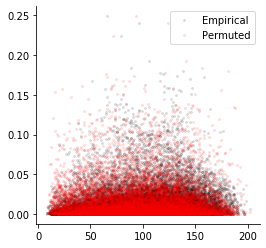

In [217]:
x = df_tau['logtau'].values

# getting pair-wise distance in vector form
x_dist = df_parcel_geo.values[np.triu_indices(len(x),k=1)]

# getting pairwise var using pdist
x_var = pdist(x[:,None])**2/2 # pdist computes and grabs upper triangle of distance matrix
# the above is identical to: 
# gen = Base(x, df_parcel_geo.values)

# make a permuted version
x_perm = np.random.permutation(x)
x_var_null = pdist(x_perm[:,None])**2/2

# plot
plt.figure(figsize=(4,4))
plt.plot(x_dist, x_var, '.k', ms=4, alpha=0.1, label='Empirical');
plt.plot(x_dist, x_var_null, '.r', ms=4, alpha=0.1, label='Permuted');
plt.legend(); despine()
pearsonr(x_dist, x_var), pearsonr(x_dist, x_var_null)

### Binning for variogram
To compute the actual variogram, we have to bin and average over some distance bins, then also smooth. My code below only does binning, and not weighting by distance from bin centers.
See: https://brainsmash.readthedocs.io/en/latest/source/brainsmash.mapgen.html#brainsmash.mapgen.Base.compute_variogram

In [219]:
def compute_variogram(x_var, x_dist, nh, pv):
    # truncate the distance distribution based on pv
    x_dist_trunc = x_dist[x_dist<=np.quantile(x_dist, pv/100)]
    x_var_trunc = x_var[x_dist<=np.quantile(x_dist, pv/100)]
    
    # evenly bin the remaining distances based on nh
    dist_bins = np.linspace(x_dist_trunc.min(), x_dist_trunc.max(), nh)
    x_dist_inds = np.digitize(x_dist_trunc, dist_bins)

    variogram = []
    for i in np.unique(x_dist_inds):
        x_curr = x_var_trunc[x_dist_inds==i]
        variogram.append([x_curr.mean(), x_curr.std()])
        
    return dist_bins, np.array(variogram)    

r = -0.332, p = 0.105


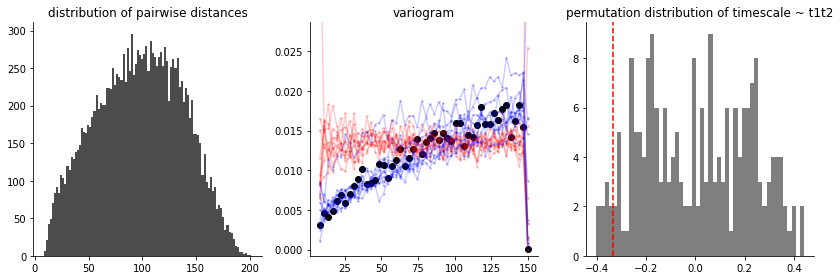

In [302]:
nh = 50
pv = 90
n_nulls = 10

# plot distribution of distances
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(x_dist, 100, color='k', alpha=0.7)
plt.title('distribution of pairwise distances')

plt.subplot(1,3,2)
# plot empirical variogram
dists, vagm = compute_variogram(x_var, x_dist, nh, pv)
plt.plot(dists, vagm[:,0], 'ok')
YL = plt.ylim()

# make a few permuted maps (that does not smooth or preserve SA, unlike in brainSMASH)
for i in range(n_nulls):    
    x_perm = np.random.permutation(x)
    x_var_null = pdist(x_perm[:,None])**2/2
    dists, vagm = compute_variogram(x_var_null, x_dist, nh, pv)
    plt.plot(dists, vagm[:,0], 'r.-', alpha=0.2, ms=3)

# make SA-preserving nulls & plot their variogram
gen = Base(x, df_parcel_geo.values, kernel='exp', nh=nh, pv=pv, resample=False)
for null in gen(n_nulls):
    x_var_null = pdist(null[:,None])**2/2
    dists, vagm = compute_variogram(x_var_null, x_dist, nh, pv)
    plt.plot(dists, vagm[:,0], 'b.-', alpha=0.2, ms=3)
    
plt.ylim([YL[0], YL[1]*1.5]);
plt.title('variogram')

# make 200 nulls and run against t1t2 map
# THIS TAKES A SECOND
n_rand = 200
nulls = gen(n_rand)
rho_null = np.array([pearsonr(n_, df_struct['T1T2'].values)[0] for n_ in nulls])
rho = pearsonr(x, df_struct['T1T2'].values)[0]

plt.subplot(1,3,3)
plt.hist(rho_null, 50, color='k', alpha=0.5);
plt.axvline(rho, color='r', ls='--')
print('r = %.3f, p = %.3f'%(rho, (abs(rho)<abs(rho_null)).sum()/n_rand))
plt.title('permutation distribution of timescale ~ t1t2')
plt.tight_layout(); despine()

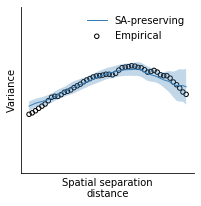

In [300]:
# compare with variogram computed from brainSMASH, not sure why the y-axis is squished
from brainsmash.mapgen.eval import base_fit
base_fit(x, df_parcel_geo.values, 10, kernel='exp', nh=nh, pv=pv, resample=False)

### Some notes on variaogram:
In this case, the null hypothesis for permuted maps is that they should preserve the variogram. There are a few parameter choices for computing variograms, especially in brainSMASH, that I don't have a good grasp on. 

For example, `pv`, which is what proportion of the pairwise distance distribution to use for fitting the variogram (how much of the x-axis to include from the left when fitting the linear model). As we see in the empirical variogram, it's non-linear past about the 70th percentile (though it's unclear how the SA-preserving nulls were still able to fit the empirical one given that it's fit with linear regression). The package uses `pv=25` as default, citing that most SA effects are local, though unclear why this choice is made and to what extent that is true?

Other parameter choices, such as kernel shape (exponential or gaussian), kernel width, % of neighbors over which to compute the variance, all affect the resulting maps.

---

# Moran Eigenvector Map 

r = -0.332, p = 0.003


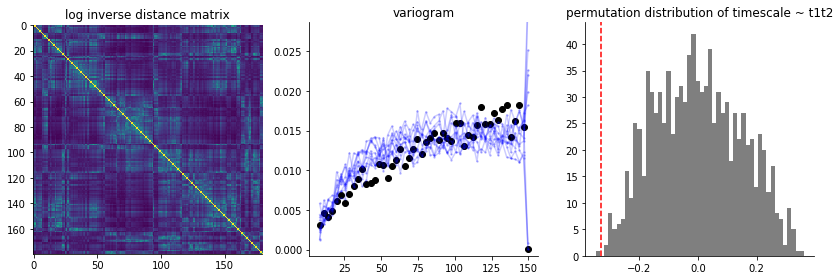

In [304]:
from brainspace.null_models import MoranRandomization

# get inverse geodesic distance map
w_igd = 1/(df_parcel_geo.values + np.eye(len(x)))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.log10(w_igd))
plt.title('log inverse distance matrix')

# do Moran decomposition on distance matrix
msr = MoranRandomization(n_rep=n_nulls, procedure='singleton', tol=1e-6, random_state=42)
msr.fit(w_igd)

# make SA-preserving nulls & plot their variogram on top of the empirical again
plt.subplot(1,3,2)
# plot empirical variogram
dists, vagm = compute_variogram(x_var, x_dist, nh, pv)
plt.plot(dists, vagm[:,0], 'ok')
YL = plt.ylim()

for null in msr.randomize(x):
    x_var_null = pdist(null[:,None])**2/2
    dists, vagm = compute_variogram(x_var_null, x_dist, nh, pv)
    plt.plot(dists, vagm[:,0], 'b.-', alpha=0.2, ms=3)
    
plt.ylim([YL[0], YL[1]*1.5]);
plt.title('variogram')

# make 1000 nulls and run against t1t2 map
n_rand = 1000
ts_msr = MoranRandomization(n_rep=n_rand, procedure='singleton', tol=1e-6, random_state=42)
ts_msr.fit(w_igd)
nulls = ts_msr.randomize(x)
rho_null = np.array([pearsonr(n_, df_struct['T1T2'].values)[0] for n_ in nulls])
rho = pearsonr(x, df_struct['T1T2'].values)[0]

plt.subplot(1,3,3)
plt.hist(rho_null, 50, color='k', alpha=0.5);
plt.axvline(rho, color='r', ls='--')
print('r = %.3f, p = %.3f'%(rho, (abs(rho)<abs(rho_null)).sum()/n_rand))
plt.title('permutation distribution of timescale ~ t1t2')
plt.tight_layout(); despine()